# Experiment A: Bound Adherence Under Nonstationary Conditions
*Question: does empirical average regret stay within the $\gamma$-regret bounds?*

### Experiment Design
Grid search over the streams (stationary, slow, abrupt, periodic), lambda levels, and two deletion ratio regimes.

Use a static comparator and calibrated learning rate schedule.
Set gamma per-theory at calibration and fix the total horizon (ie. $T=50000$).

### Primary Analysis
For each of the experimental cells, evaluate the final $R_{T}/T$ to see whether the guarantee was met.
Multiple seeds per cell in order to make some kind of causal analysis on the results.

### Success Criteria
95% of the cells meet their guarantees then I would call that a success. Which cells experience more successes than others? Can I make a heatmap that shows the regret results per cell?

## Import Statements and Versioning

This uses pretty standard library imports, but the torch requirement can stress the memory limits of a host.

In [1]:
# set global seed
import random
import numpy as np
import pandas as pd
import torch

def set_seed(seed):
    """
    Set the random seed for reproducibility.
    
    Args:
        seed (int): The seed value to set for random number generation.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Config and Target

In [2]:
RUN_ID = "experiment_a_test"
REGIME = "stationary"
REPLICATE = 1
T = 1000
SEED = 42
LOSS_NAME = "logistic"
MODEL_NAME = "memorypair"
LBFGS_MEM = 10

# Setup and Imports

In [3]:
# Import required modules
import sys
import os

# Add code path for imports
os.chdir(os.path.dirname(os.getcwd()))

from config import Config
from runner import ExperimentRunner

from agents.grid_runner import load_grid, generate_combinations, create_grid_id, run_parameter_combination


SyntaxError: 'return' outside function (linear.py, line 71)

## Reading and Transforming the Data 

The data is now in a series of files in the results folder. This section will read in those datapoints and output a fully formatted dataframe of a random sample of the datapoints.

Analysis can be performed in batches.

In [ ]:
# print a count of all directories in the results directory
dir_list = []
results_dir = "results/grid_2025_08_15/"
for r, d, files in os.walk(results_dir):
    for dirname in d:
        dir_list.append(os.path.join(r, dirname))
print(f"Number of directories in '{results_dir}': {len(dir_list)}")
print(dir_list)

Number of directories in 'results/grid_2025_08_15/': 34
['results/grid_2025_08_15/sweep', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h3ebe6677', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h303e9151', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_hd0eaf007', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_prot_ang0.01_dr0.001_fs1_hafba7de0', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_prot_ang0.01_dr0.001_fs1_h6a12174f', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h6cf5bec1', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h881e0dba', 'results/grid_2025_08_15/swee

In [ ]:
# sample 12 of the directories
sampled_directories = dir_list
print(sampled_directories)

# read them into a dataframe

# go up a single level in the current directory
sys.path.append(os.path.dirname(os.getcwd()))


event_data = []
parameter_data = []
for d in sampled_directories:
    # ingest all csv files
    for f in os.listdir(d):
        if f.endswith('1.0.csv'):
            df = pd.read_csv(os.path.join(d, f))
            df['grid_id'] = d.split('/')[-1]
            # append the seed from the filename
            df['seed'] = int(f.split('_')[1])
            event_data.append(df)
        elif f.endswith('.json'):
            df = pd.read_json(os.path.join(d, f))
            df['grid_id'] = d.split('/')[-1]
            parameter_data.append(df)

# concatenate all dataframes
event_data = pd.concat(event_data, ignore_index=True)
parameter_data = pd.concat(parameter_data)


['results/grid_2025_08_15/sweep', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h3ebe6677', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h303e9151', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_hd0eaf007', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_prot_ang0.01_dr0.001_fs1_hafba7de0', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_prot_ang0.01_dr0.001_fs1_h6a12174f', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h6cf5bec1', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h881e0dba', 'results/grid_2025_08_15/sweep/gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_prot_ang0

In [ ]:
# print unique comparator types
print(static_comparator_events['comparator_type'].unique())

NameError: name 'static_comparator_events' is not defined

In [ ]:
# isolate those grid ids without cmpdynamic
static_comparator_events = event_data[event_data["comparator_type"] != "dynamic"]

# count the number of rows, non-null regret values, and g_hat for each grid ID
static_comparator_events.groupby('grid_id').agg(
    num_rows=('event', 'size'),
    num_non_null_regret=('regret', 'count'),
    avg_g_hat=('G_hat', 'mean')
)

,num_rows,num_non_null_regret,avg_g_hat
grid_id,,,
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h11625dba,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h18c0b99c,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h1f62b5d9,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h303e9151,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h3ebe6677,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h5ccc6a83,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h5d43ac50,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h6a12174f,49750,2500,37.284058
gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h6cf5bec1,49750,2500,37.284058


In [ ]:
# create a dataframe of all seed 1
seed_1_df = event_data[event_data['seed'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(seed_1_df['event'], seed_1_df['regret'], marker='o')
plt.title('Regret vs Event (Seed 1)')
plt.xlabel('Event')
plt.ylabel('Regret')
plt.grid()
plt.show()

NameError: name 'plt' is not defined

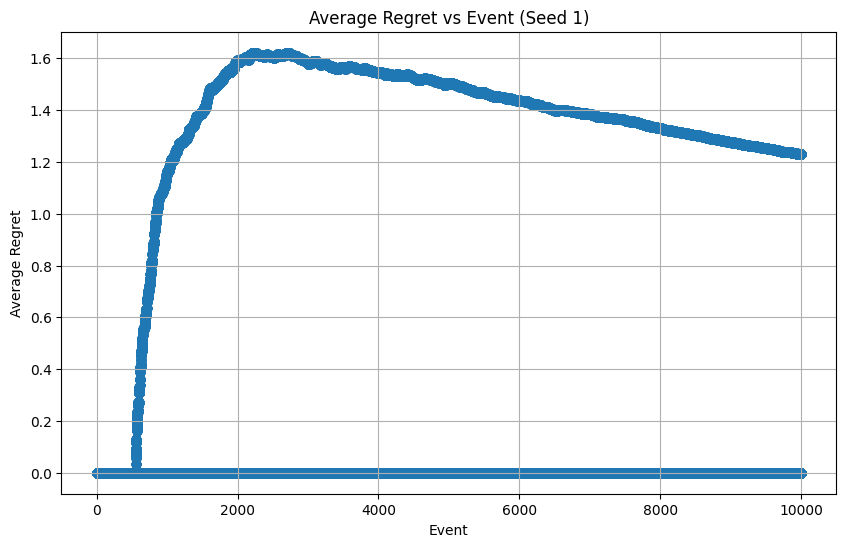

In [ ]:
# create a dataframe of all seed 1
seed_1_df = event_data[event_data['seed'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(seed_1_df['event'], seed_1_df['avg_regret'], marker='o')
plt.title('Average Regret vs Event (Seed 1)')
plt.xlabel('Event')
plt.ylabel('Average Regret')
plt.grid()
plt.show()

In [ ]:
# print regret quartiles per grid id
for grid_id, group in event_data.groupby('grid_id'):
    print(f"Grid ID: {grid_id}")
    print(group['regret'].describe(percentiles=[.25, .5, .75]))

Grid ID: gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h11625dba
count    2500.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: regret, dtype: float64
Grid ID: gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h18c0b99c
count    2500.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: regret, dtype: float64
Grid ID: gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h1f62b5d9
count    2500.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: regret, dtype: float64
Grid ID: gamma_1.0-split_0.5_q0.95_k10_default_eps1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_h303e9151
count    2500.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%  

In [ ]:
event_data.head()
print(event_data.columns)

Index(['C_hat', 'D_hat', 'G_hat', 'N_gamma', 'N_star_theory', 'P_T', 'P_T_est',
       'S_scalar', 'acc', 'accountant', 'avg_regret', 'avg_regret_with_noise',
       'base_eta_t', 'c_hat', 'comparator_type', 'cum_regret',
       'cum_regret_with_noise', 'delta_step_theory', 'delta_total',
       'drift_boost_remaining', 'drift_flag', 'eps_remaining', 'eps_spent',
       'eps_step_theory', 'eta_t', 'event', 'event_id', 'event_type',
       'lambda_est', 'm_capacity', 'm_used', 'noise_regret_cum',
       'noise_regret_increment', 'op', 'regret', 'regret_dynamic',
       'regret_increment', 'regret_path_term', 'regret_static_term',
       'rho_remaining', 'rho_spent', 'rho_step', 'sample_id', 'segment_id',
       'sens_delete', 'sigma_step', 'sigma_step_theory', 'x_norm', 'grid_id',
       'seed'],
      dtype='object')


In [ ]:
micro_analysis = event_data[['grid_id', 'seed', 'event', 'regret']].copy()

micro_analysis['regret'].value_counts()

regret
0.000000        82500
15939.350043       30
6974.644106        30
15915.552510       30
6981.666626        30
                ...  
26049.381876       15
26050.728826       15
26050.729829       15
26050.871267       15
26026.153563       15
Name: count, Length: 44091, dtype: int64